# Del 14: Procesiranje velikih datasetov v pandas-u

Pandas omejen z RAM-om
- orodje za bigData https://spark.apache.org/, ki podatke obdelujejo v clustru (ni vezano samo na python)
- Dask:
    - ogrodje za skaliranje python toolov https://www.dask.org/
    - moznost paralizacije tudi za single machine https://docs.dask.org/en/stable/10-minutes-to-dask.html

## Introduction & Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
moma = pd.read_csv('data/MoMAExhibitions1929to1989.csv')

In [3]:
moma.head(2)

ExhibitionID ExhibitionNumber                     ExhibitionTitle  \
0        2557.0                1  Cézanne, Gauguin, Seurat, Van Gogh   
1        2557.0                1  Cézanne, Gauguin, Seurat, Van Gogh   

                        ExhibitionCitationDate ExhibitionBeginDate  \
0  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   
1  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   

  ExhibitionEndDate  ExhibitionSortOrder  \
0         12/7/1929                  1.0   
1         12/7/1929                  1.0   

                                   ExhibitionURL ExhibitionRole  \
0  http://www.moma.org/calendar/exhibitions/1767       Director   
1  http://www.moma.org/calendar/exhibitions/1767         Artist   

   ConstituentID  ... Institution Nationality ConstituentBeginDate  \
0         9168.0  ...         NaN    American               1902.0   
1         1053.0  ...         NaN      French               1839.0   

  ConstituentEndDate            ArtistBio Gender       VIAFID WikidataID  \
0             1981.0  American, 1902–1981   Male  109252853.0    Q711362   
1             1906.0    French, 1839–1906   Male   39374836.0     Q35548   

        ULANID         ConstituentURL  
0  500241556.0  moma.org/artists/9168  
1  500004793.0  moma.org/artists/1053  

[2 rows x 27 columns]

In [4]:
moma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ExhibitionID            34129 non-null  float64
 1   ExhibitionNumber        34558 non-null  object 
 2   ExhibitionTitle         34558 non-null  object 
 3   ExhibitionCitationDate  34557 non-null  object 
 4   ExhibitionBeginDate     34558 non-null  object 
 5   ExhibitionEndDate       33354 non-null  object 
 6   ExhibitionSortOrder     34558 non-null  float64
 7   ExhibitionURL           34125 non-null  object 
 8   ExhibitionRole          34424 non-null  object 
 9   ConstituentID           34044 non-null  float64
 10  ConstituentType         34424 non-null  object 
 11  DisplayName             34424 non-null  object 
 12  AlphaSort               34424 non-null  object 
 13  FirstName               31499 non-null  object 
 14  MiddleName              3804 non-null 

## Measuring the memory usage of a Pandas DataFrame



### The Internal Representation of a Dataframe

<img src="./images/pandas_dataframe_blocks.png">

In [5]:
moma._data

BlockManager
Items: Index(['ExhibitionID', 'ExhibitionNumber', 'ExhibitionTitle',
       'ExhibitionCitationDate', 'ExhibitionBeginDate', 'ExhibitionEndDate',
       'ExhibitionSortOrder', 'ExhibitionURL', 'ExhibitionRole',
       'ConstituentID', 'ConstituentType', 'DisplayName', 'AlphaSort',
       'FirstName', 'MiddleName', 'LastName', 'Suffix', 'Institution',
       'Nationality', 'ConstituentBeginDate', 'ConstituentEndDate',
       'ArtistBio', 'Gender', 'VIAFID', 'WikidataID', 'ULANID',
       'ConstituentURL'],
      dtype='object')
Axis 1: RangeIndex(start=0, stop=34558, step=1)
NumericBlock: [ 0  6  9 19 20 23 25], 7 x 34558, dtype: float64
ObjectBlock: [ 1  2  3  4  5  7  8 10 11 12 13 14 15 16 17 18 21 22 24 26], 20 x 34558, dtype: object

### Dataframe Memory Footprint

#### Numbers (int, float) and other fixed-size objects

In [6]:
series = pd.Series([123] * 1_000_000, dtype=np.int64)

In [7]:
series.memory_usage()

8000128

In [8]:
series.memory_usage(deep=True)

8000128

#### Example: moma dataset - float clomun

In [9]:
34558*8

276464

In [11]:
moma['ExhibitionID'].nbytes

276464

#### Object Columns (arbitrarily-sized objects)

<img src="./images/numpy_vs_python.png">

In [12]:
total_bytes = moma.size*8

In [14]:
total_megabytes = total_bytes/(1024*1024)

In [15]:
print('Total bytes:', total_bytes)
print('Total megabytes:', total_megabytes)

Total bytes: 7464528
Total megabytes: 7.1187286376953125


In [19]:
# moma.info() 7.1+ MB -> vrednost brez stringov, v numpy matriki samo naslovi do data objektov (shranjeni stringi)

moma.info(memory_usage='deep') # 45.6 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ExhibitionID            34129 non-null  float64
 1   ExhibitionNumber        34558 non-null  object 
 2   ExhibitionTitle         34558 non-null  object 
 3   ExhibitionCitationDate  34557 non-null  object 
 4   ExhibitionBeginDate     34558 non-null  object 
 5   ExhibitionEndDate       33354 non-null  object 
 6   ExhibitionSortOrder     34558 non-null  float64
 7   ExhibitionURL           34125 non-null  object 
 8   ExhibitionRole          34424 non-null  object 
 9   ConstituentID           34044 non-null  float64
 10  ConstituentType         34424 non-null  object 
 11  DisplayName             34424 non-null  object 
 12  AlphaSort               34424 non-null  object 
 13  FirstName               31499 non-null  object 
 14  MiddleName              3804 non-null 

> **index** : *bool, default True* --> 
Specifies whether to include the memory usage of the DataFrame’s index in returned Series. If index=True, the memory usage of the index is the first item in the output.

In [20]:
moma.memory_usage(deep=True, index=False)

ExhibitionID               276464
ExhibitionNumber          2084650
ExhibitionTitle           3333695
ExhibitionCitationDate    3577728
ExhibitionBeginDate       2281851
ExhibitionEndDate         2234872
ExhibitionSortOrder        276464
ExhibitionURL             3494606
ExhibitionRole            2179383
ConstituentID              276464
ConstituentType           2313112
DisplayName               2548428
AlphaSort                 2534329
FirstName                 2104889
MiddleName                1218881
LastName                  2162933
Suffix                    1110317
Institution               1221368
Nationality               1949664
ConstituentBeginDate       276464
ConstituentEndDate         276464
ArtistBio                 3183300
Gender                    1858994
VIAFID                     276464
WikidataID                1821293
ULANID                     276464
ConstituentURL            2677922
dtype: int64

In [ ]:
moma["ExhibitionTitle"].memory_usage()/1024/1024

In [ ]:
moma["ExhibitionTitle"].memory_usage(deep=True)/1024/1024

In [ ]:
import sys
(sum([sys.getsizeof(s) for s in moma["ExhibitionTitle"]]) + moma["ExhibitionTitle"].memory_usage())/1024/1024

### Getting memory usage by type

In [21]:
def get_memory_usage_by_type(df, types=[]):
    if not types:
        types = []
        for column in df.columns:
            if hasattr(df[column], 'cat'):
                types.append('category')
            else:
                types.append(df[column].dtype)
        types = list(set(types))
    total = 0
    for dtype in types:
        selected_dtype = df.select_dtypes(include=[dtype])
        num_of_columns = len(selected_dtype.columns)
        mean_usage_b = selected_dtype.memory_usage(deep=True, index=False).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        sum_usage_b = selected_dtype.memory_usage(deep=True, index=False).sum()
        sum_usage_mb = sum_usage_b / 1024 ** 2
        print(f"Average memory usage: {round(mean_usage_mb, 3)} MB and total: {round(sum_usage_mb, 3)} MB for {num_of_columns}x {dtype} columns.")
        total += sum_usage_mb
        
    print('----------------------')
    print(f'Total memory usage: {round(total, 3)} MB')

In [22]:
get_memory_usage_by_type(moma)

Average memory usage: 2.188 MB and total: 43.766 MB for 20x object columns.
Average memory usage: 0.264 MB and total: 1.846 MB for 7x float64 columns.
----------------------
Total memory usage: 45.612 MB


## Optimizing Dataframe Memory Footprint

### Dropping columns
Že pri branju izberemo samo kateri stolpci nas zanimajo

In [23]:
moma_sample = pd.read_csv("data/MoMAExhibitions1929to1989.csv", nrows=3)

In [24]:
moma_sample

ExhibitionID  ExhibitionNumber                     ExhibitionTitle  \
0          2557                 1  Cézanne, Gauguin, Seurat, Van Gogh   
1          2557                 1  Cézanne, Gauguin, Seurat, Van Gogh   
2          2557                 1  Cézanne, Gauguin, Seurat, Van Gogh   

                        ExhibitionCitationDate ExhibitionBeginDate  \
0  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   
1  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   
2  [MoMA Exh. #1, November 7-December 7, 1929]           11/7/1929   

  ExhibitionEndDate  ExhibitionSortOrder  \
0         12/7/1929                    1   
1         12/7/1929                    1   
2         12/7/1929                    1   

                                   ExhibitionURL ExhibitionRole  \
0  http://www.moma.org/calendar/exhibitions/1767       Director   
1  http://www.moma.org/calendar/exhibitions/1767         Artist   
2  http://www.moma.org/calendar/exhibitions/1767         Artist   

   ConstituentID  ... Institution Nationality ConstituentBeginDate  \
0           9168  ...         NaN    American                 1902   
1           1053  ...         NaN      French                 1839   
2           2098  ...         NaN      French                 1848   

  ConstituentEndDate            ArtistBio Gender     VIAFID  WikidataID  \
0               1981  American, 1902–1981   Male  109252853     Q711362   
1               1906    French, 1839–1906   Male   39374836      Q35548   
2               1903    French, 1848–1903   Male   27064953      Q37693   

      ULANID         ConstituentURL  
0  500241556  moma.org/artists/9168  
1  500004793  moma.org/artists/1053  
2  500011421  moma.org/artists/2098  

[3 rows x 27 columns]

In [25]:
# da dobimo imena vseh stolpcev
moma_sample.columns.tolist()

['ExhibitionID',
 'ExhibitionNumber',
 'ExhibitionTitle',
 'ExhibitionCitationDate',
 'ExhibitionBeginDate',
 'ExhibitionEndDate',
 'ExhibitionSortOrder',
 'ExhibitionURL',
 'ExhibitionRole',
 'ConstituentID',
 'ConstituentType',
 'DisplayName',
 'AlphaSort',
 'FirstName',
 'MiddleName',
 'LastName',
 'Suffix',
 'Institution',
 'Nationality',
 'ConstituentBeginDate',
 'ConstituentEndDate',
 'ArtistBio',
 'Gender',
 'VIAFID',
 'WikidataID',
 'ULANID',
 'ConstituentURL']

In [26]:
keep_cols = ['ExhibitionID', 'ExhibitionNumber', 'ExhibitionBeginDate', 
             'ExhibitionEndDate', 'DisplayName', 'Institution']

In [27]:
moma_small = pd.read_csv('data/MoMAExhibitions1929to1989.csv',
                    usecols=keep_cols)

In [28]:
get_memory_usage_by_type(moma_small)

Average memory usage: 1.978 MB and total: 9.891 MB for 5x object columns.
Average memory usage: 0.264 MB and total: 0.264 MB for 1x float64 columns.
----------------------
Total memory usage: 10.154 MB


### Optimizing Numeric Columns with Smaller Subtypes

<table>
<thead>
<tr>
<th>memory usage</th>
<th>float</th>
<th>int</th>
<th>uint</th>
<th>datetime</th>
<th>bool</th>
<th>object</th>
</tr>
</thead>
<tbody>
<tr>
<td>1 bytes</td>
<td></td>
<td>int8</td>
<td>uint8</td>
<td></td>
<td>bool</td>
<td></td>
</tr>
<tr>
<td>2 bytes</td>
<td>float16</td>
<td>int16</td>
<td>uint16</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>4 bytes</td>
<td>float32</td>
<td>int32</td>
<td>uint32</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>8 bytes</td>
<td>float64</td>
<td>int64</td>
<td>uint64</td>
<td>datetime64</td>
<td></td>
<td></td>
</tr>
<tr>
<td>variable</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>object</td>
</tr>
</tbody>
</table>

In [29]:
int_types = ["int8", "int16", "int32", "int64"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------



In [30]:
np.iinfo('int8').min

-128

In [31]:
np.iinfo('int8').max

127

#### Integer Columns

In [32]:
# Error
# moma['ConstituentID'].astype('int')

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [34]:
moma.select_dtypes(include=['float']).isnull().sum() # iz dataframe-a izbere samo določene stolpce glede na njihov tip

ExhibitionID              429
ExhibitionSortOrder         0
ConstituentID             514
ConstituentBeginDate     9268
ConstituentEndDate      14739
VIAFID                   7562
ULANID                  12870
dtype: int64

In [ ]:
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")
moma.select_dtypes(include=['float']).head()

In [35]:
get_memory_usage_by_type(moma)

Average memory usage: 2.188 MB and total: 43.766 MB for 20x object columns.
Average memory usage: 0.264 MB and total: 1.846 MB for 7x float64 columns.
----------------------
Total memory usage: 45.612 MB


In [36]:
moma.dtypes.value_counts()

object     20
float64     7
dtype: int64

In [37]:
# Function to convert to best integer subtype
def convert_col_to_best_int_subtype(df, columns=[]):
    for column in columns:
        col_max = df[column].max()
        col_min = df[column].min()
        if col_max < np.iinfo('int8').max and col_min > np.iinfo('int8').min:
            print(f"Column {column} converted to int8.")
            df[column] = df[column].astype('int8')
        elif col_max <  np.iinfo("int16").max and col_min > np.iinfo("int16").min:
            print(f"Column {column} converted to int16.")
            df[column] = df[column].astype("int16")
        elif col_max <  np.iinfo("int32").max and col_min > np.iinfo("int32").min:
            print(f"Column {column} converted to int32.")
            df[column] = df[column].astype("int32")
        elif col_max <  np.iinfo("int64").max and col_min > np.iinfo("int64").min:
            print(f"Column {column} converted to int64.")
            df[column] = df[column].astype("int64")

In [38]:
convert_col_to_best_int_subtype(moma, ['ExhibitionSortOrder'])

Column ExhibitionSortOrder converted to int16.


In [39]:
moma.dtypes.value_counts()

object     20
float64     6
int16       1
dtype: int64

In [40]:
get_memory_usage_by_type(moma)

Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
Average memory usage: 2.188 MB and total: 43.766 MB for 20x object columns.
Average memory usage: 0.264 MB and total: 1.582 MB for 6x float64 columns.
----------------------
Total memory usage: 45.414 MB


#### Float Columns

In [41]:
len(moma) * 2 + 128

69244

In [42]:
moma['ExhibitionSortOrder'].memory_usage(deep=True)

69244

In [43]:
# Reset the dataframe to the original CSV
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")

moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype('int')
moma['ExhibitionSortOrder'].dtype

dtype('int64')

In [44]:
# Reset the dataframe to the original CSV
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")

moma['ExhibitionSortOrder'] = moma['ExhibitionSortOrder'].astype('int')
moma['ExhibitionSortOrder'] = pd.to_numeric(moma['ExhibitionSortOrder'], 
                                           downcast='integer')

moma['ExhibitionSortOrder'].dtype

dtype('int16')

In [46]:
# Reset the dataframe to the original CSV
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")
moma['ExhibitionSortOrder'] = pd.to_numeric(moma['ExhibitionSortOrder'], 
                                            downcast='integer')

moma['ExhibitionSortOrder'].dtype

dtype('float64')

In [47]:
moma = pd.read_csv("data/MoMAExhibitions1929to1989.csv")
get_memory_usage_by_type(moma)
# convert int columns
convert_col_to_best_int_subtype(moma, ['ExhibitionSortOrder'])
# convert folat columns
float_cols = moma.select_dtypes(include=['float'])
for col in float_cols.columns:
    moma[col] = pd.to_numeric(moma[col], downcast='float')

Average memory usage: 2.188 MB and total: 43.766 MB for 20x object columns.
Average memory usage: 0.264 MB and total: 1.846 MB for 7x float64 columns.
----------------------
Total memory usage: 45.612 MB
Column ExhibitionSortOrder converted to int16.


In [48]:
moma.dtypes.value_counts()

object     20
float32     4
float64     2
int16       1
dtype: int64

In [49]:
get_memory_usage_by_type(moma)

Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
Average memory usage: 2.188 MB and total: 43.766 MB for 20x object columns.
Average memory usage: 0.132 MB and total: 0.527 MB for 4x float32 columns.
Average memory usage: 0.176 MB and total: 1.055 MB for 6x float64 columns.
----------------------
Total memory usage: 45.414 MB


### Converting String To DateTime

In [ ]:
moma.head(3)

In [ ]:
moma['ExhibitionEndDate'].isnull().sum()

In [ ]:
moma['ExhibitionEndDate'] = pd.to_datetime(moma['ExhibitionEndDate'])

In [ ]:
# format parameter -> faster 
moma['ExhibitionBeginDate'] = pd.to_datetime(moma['ExhibitionBeginDate'], format='%m/%d/%Y')

In [ ]:
moma.dtypes.value_counts()

In [ ]:
get_memory_usage_by_type(moma)

### Converting to Categorical

In [50]:
moma['ConstituentType'].unique()

array(['Individual', nan, 'Institution'], dtype=object)

In [51]:
moma['ConstituentType'].value_counts()

Individual     32008
Institution     2416
Name: ConstituentType, dtype: int64

In [52]:
moma['ConstituentType'].memory_usage(deep=True)

2313240

In [53]:
moma['ConstituentType'] = moma['ConstituentType'].astype('category')

In [54]:
get_memory_usage_by_type(moma)

Average memory usage: 2.187 MB and total: 41.56 MB for 19x object columns.
Average memory usage: 0.033 MB and total: 0.033 MB for 1x category columns.
Average memory usage: 0.176 MB and total: 1.055 MB for 6x float64 columns.
Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
Average memory usage: 0.132 MB and total: 0.527 MB for 4x float32 columns.
----------------------
Total memory usage: 43.241 MB


In [55]:
moma['ConstituentType'].head()

0    Individual
1    Individual
2    Individual
3    Individual
4    Individual
Name: ConstituentType, dtype: category
Categories (2, object): ['Individual', 'Institution']

In [56]:
obj_col = moma.select_dtypes(include=['object'])

In [59]:
# ocenimo ali se splaca pretvoriti v category data
for col in obj_col.columns:
    num_unique_values = len(moma[col].unique())
    num_total_values = len(moma[col])
    
    if num_unique_values / num_total_values < 0.5:
        moma[col] = moma[col].astype('category')

In [58]:
get_memory_usage_by_type(moma)

Average memory usage: 0.066 MB and total: 0.066 MB for 1x int16 columns.
Average memory usage: 0.132 MB and total: 0.527 MB for 4x float32 columns.
Average memory usage: 0.176 MB and total: 1.055 MB for 6x float64 columns.
Average memory usage: 0.376 MB and total: 7.518 MB for 20x category columns.
----------------------
Total memory usage: 9.166 MB


### Sparse columns

- https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html
- https://pythonspeed.com/articles/pandas-load-less-data/

### Example:  Selecting Types While Reading the Data In
Ce preberemo za v optimalnem tipu ze v osnovi manjsi footprint v spominu

In [ ]:
moma_sample = pd.read_csv("data/MoMAExhibitions1929to1989.csv", nrows=3)

In [ ]:
moma_sample

In [ ]:
# da dobimo imena vseh stolpcev
moma_sample.columns.tolist()

In [ ]:
keep_cols = ['ExhibitionID', 'ExhibitionNumber', 'ExhibitionBeginDate', 
             'ExhibitionEndDate', 'ExhibitionSortOrder', 'ExhibitionRole', 
             'ConstituentType', 'DisplayName', 'Institution', 'Nationality', 
             'Gender']

In [ ]:
col_types = {'ExhibitionID': np.float32, 
             'ExhibitionNumber': 'category',
             'ExhibitionSortOrder': np.float16, 
             'ExhibitionRole': 'category', 
             'ConstituentType' : 'category', 
             'DisplayName' : 'category', 
             'Institution': 'category',  
             'Nationality' : 'category', 
             'Gender': 'category'}

In [ ]:
date_cols = ["ExhibitionBeginDate", "ExhibitionEndDate"]

In [ ]:
moma = pd.read_csv('data/MoMAExhibitions1929to1989.csv',
                    usecols=keep_cols,
                    parse_dates=date_cols,
                    dtype=col_types)

In [ ]:
get_memory_usage_by_type(moma)

## Processing Dataframes in Chunks

### Processing Chunks

<img src="./images/processing_chunks_overview.png">

In [60]:
import pandas as pd
import numpy as np

In [61]:
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=10000)

In [62]:
print(type(chunk_iter))

<class 'pandas.io.parsers.readers.TextFileReader'>


In [63]:
for chunk in chunk_iter:
    print(len(chunk))

10000
10000
10000
4558


In [66]:
# Create an iterator object that reads in 250-row chunks from "moma.csv".
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250)

In [67]:
# For each chunk, retrieve the memory footprint in megabytes and append it to the list memory_footprints.
memory_footprints = []

for chunk in chunk_iter:
    memory_footprints.append(chunk.memory_usage(deep=True).sum()/(1024*1024))

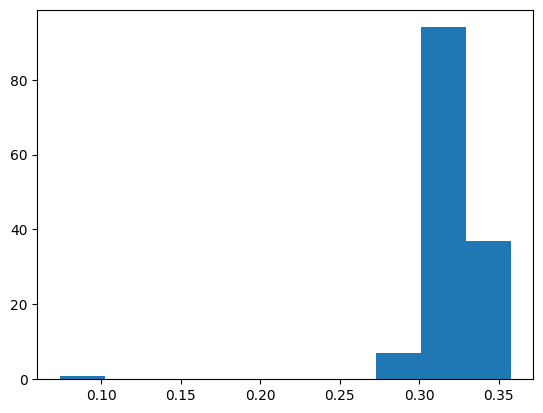

In [68]:
# Generate and display a histogram of the values in memory_footprints using pyplot.hist()
import matplotlib.pyplot as plt

plt.hist(memory_footprints)
plt.show()

### Counting Across Chunks

In [ ]:
# Create an iterator object that reads in 250-row chunks from "moma.csv".
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250)

In [ ]:
# For each chunk, retrieve the number of rows and add it to num_rows.
num_rows = 0

for chunk in chunk_iter:
    num_rows += len(chunk) 

In [ ]:
num_rows

### Batch Processing

<img src="./images/process_chunks_count.png">

In [69]:
series_list = [pd.Series([1,2]), pd.Series([2,3])]

pd.concat(series_list)

0    1
1    2
0    2
1    3
dtype: int64

In [70]:
lifespans = []

In [71]:
dtypes = { 'ConstituentBeginDate': 'float',
          'ConstituentEndDate': 'float'}

chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", 
                         chunksize=250,
                        dtype=dtypes)

In [72]:
for chunk in chunk_iter:
    diff = chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate']
    lifespans.append(diff)

In [73]:
lifespans_dist = pd.concat(lifespans)

In [74]:
lifespans_dist.head()

0    79.0
1    67.0
2    55.0
3    37.0
4    32.0
dtype: float64

### Optimizing Performance

In [75]:
%%timeit
lifespans = []

chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=250, 
                         dtype={"ConstituentBeginDate": "float", "ConstituentEndDate": "float"})

for chunk in chunk_iter:
    lifespans.append(chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate'])

lifespans_dist = pd.concat(lifespans)

337 ms ± 34.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
%%timeit
lifespans = []

chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv", chunksize=500, 
                         dtype={"ConstituentBeginDate": "float", "ConstituentEndDate": "float"},  
                         usecols=['ConstituentBeginDate', 'ConstituentEndDate'])

for chunk in chunk_iter:
    lifespans.append(chunk['ConstituentEndDate'] - chunk['ConstituentBeginDate'])
    
lifespans_dist = pd.concat(lifespans)

93.1 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Counting Unique Values

<img src="./images/processing_chunks_value_counts.png">

In [78]:
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv",
                         chunksize=250, usecols=['Gender'])

In [79]:
overall_vc = []

for chunk in chunk_iter:
    chunk_vc = chunk['Gender'].value_counts()
    overall_vc.append(chunk_vc)
    
combined_vc = pd.concat(overall_vc) 

In [80]:
combined_vc.head(10)

Male      208
Female      9
Male      193
Female      6
Male      195
Female      8
Male      104
Female      6
Male      103
Female     10
Name: Gender, dtype: int64

### Combining Chunks Using GroupBy

In [81]:
chunk_iter = pd.read_csv("data/MoMAExhibitions1929to1989.csv",
                         chunksize=250, usecols=['Gender'])

overall_vc = []

for chunk in chunk_iter:
    chunk_vc = chunk['Gender'].value_counts()
    overall_vc.append(chunk_vc)
    
combined_vc = pd.concat(overall_vc) 

In [82]:
final_vc = combined_vc.groupby(combined_vc.index).sum()

In [83]:
final_vc

Female     2527
Male      23268
male          1
Name: Gender, dtype: int64

## Analizing big files with Pandas and SQLite

In [84]:
import sqlite3

In [85]:
conn = sqlite3.connect('data/moma.db')

In [86]:
moma_iter = pd.read_csv('data/moma.csv', chunksize=1000)

In [87]:
# chunk po chunk beremo in nato pišemo v SQLite
for chunk in moma_iter:
    chunk.to_sql('exhibitions', conn, if_exists='append', index=False)

### Computing Primarily in SQL

In [88]:
conn = sqlite3.connect('data/moma.db')

In [89]:
q = '''SELECT exhibitionid, count(*) AS counts 
    from exhibitions 
    GROUP BY exhibitionid 
    ORDER BY counts desc;'''

In [90]:
eid_counts = pd.read_sql(q, conn)

In [91]:
conn.close()

In [92]:
eid_counts.head(10)

ExhibitionID  counts
0           NaN    2145
1           7.0    1605
2        3838.0    1510
3        3030.0    1420
4        3988.0    1375
5        2600.0    1310
6          79.0    1295
7       10601.0    1280
8        3939.0    1270
9        3036.0    1220

### Computing Primarily in Pandas

In [ ]:
conn = sqlite3.connect('data/moma.db')

In [ ]:
q = 'SELECT exhibitionid FROM exhibitions'

In [ ]:
eid_counts = pd.read_sql(q, conn)

In [ ]:
conn.close()

In [ ]:
eid_counts.head()

In [ ]:
eid_pandas_counts = eid_counts['ExhibitionID'].value_counts(dropna=False)

In [ ]:
eid_pandas_counts.head(10)

### Reading in SQL Results Using Chunks

In [93]:
conn = sqlite3.connect('data/moma.db')

In [94]:
%%timeit
q = 'select exhibitionid from exhibitions;'
chunk_iter = pd.read_sql(q, conn, chunksize=100)

for chunk in chunk_iter:
    eid_pandas_counts = eid_counts['ExhibitionID'].value_counts()

751 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
%%timeit
q = 'select exhibitionid from exhibitions;'
chunk_iter = pd.read_sql(q, conn, chunksize=1000)

for chunk in chunk_iter:
    eid_pandas_counts = eid_counts['ExhibitionID'].value_counts()

146 ms ± 988 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
%%timeit
q = 'select exhibitionid from exhibitions;'
chunk_iter = pd.read_sql(q, conn, chunksize=10000)

for chunk in chunk_iter:
    eid_pandas_counts = eid_counts['ExhibitionID'].value_counts()

84.9 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Vaja: Primer analize velikega dataseta

In [ ]:
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                        encoding='ISO-8859-1')

In [ ]:
mv_list = []

for chunk in chunk_iter:
    print(chunk.memory_usage(deep=True).sum() / (1024 * 1024))
    mv_list.append(chunk.isnull().sum())

In [ ]:
combined_mv_vc = pd.concat(mv_list)

In [ ]:
combined_mv_vc.head(5)

In [ ]:
unique_combined_mv_vc = combined_mv_vc.groupby(combined_mv_vc.index).sum()

In [ ]:
unique_combined_mv_vc.sort_values()

In [ ]:
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                        encoding='ISO-8859-1')

In [ ]:
counter = 0
series_memory_fp = pd.Series(dtype='float64')

In [ ]:
for chunk in chunk_iter:
    if counter == 0:
        series_memory_fp = chunk.memory_usage(deep=True)
    else: 
        series_memory_fp += chunk.memory_usage(deep=True)
    counter += 1

In [ ]:
# Drop memory footprint calculation for the index.
series_memory_fp = series_memory_fp.drop('Index')

In [ ]:
series_memory_fp.sum() / (1024 * 1024)

In [ ]:
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                        encoding='ISO-8859-1')
total_rows = 0
for chunk in chunk_iter:
    total_rows += len(chunk)

print(total_rows)

In [ ]:
unique_combined_mv_vc.sort_values()/total_rows*100

In [ ]:
# Drop columns representing URL's or containing way too many missing values (>90% missing)
drop_cols = ['investor_permalink', 'company_permalink', 
             'investor_category_code']

In [ ]:
keep_cols = chunk.columns.drop(drop_cols)

In [ ]:
keep_cols.tolist()

In [ ]:
# Key: Column name, Value: List of types
col_types = {}
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                         encoding='ISO-8859-1', 
                         usecols=keep_cols)

for chunk in chunk_iter:
    for col in chunk.columns:
        if col not in col_types:
            col_types[col] = [str(chunk.dtypes[col])]
        else:
            col_types[col].append(str(chunk.dtypes[col]))

In [ ]:
uniq_col_types = {}
for k,v in col_types.items():
    uniq_col_types[k] = set(col_types[k])
uniq_col_types

In [ ]:
import sqlite3
conn = sqlite3.connect('data/crunchbase.db')
chunk_iter = pd.read_csv('data/crunchbase-investments.csv', 
                         chunksize=5000, 
                         encoding='ISO-8859-1',
                         usecols=keep_cols)

for chunk in chunk_iter:
    chunk.to_sql("investments", conn, if_exists='append', index=False)

In [ ]:
# previmo z podatke
q = "SELECT * FROM investments LIMIT 5;"
data_5 = pd.read_sql(q, conn)

In [ ]:
data_5

In [ ]:
q = '''SELECT company_category_code, count(*) AS counts 
    from investments 
    GROUP BY company_category_code 
    ORDER BY counts desc;'''

In [ ]:
data = pd.read_sql(q, conn)

In [ ]:
data.head()

In [ ]:
data.head(10).plot(kind='bar', 
          x='company_category_code', 
          y='counts', 
          legend=False)

plt.show()

## More file formats

- [Big Data file formats](https://luminousmen.com/post/big-data-file-formats)

### [Parquet](https://parquet.apache.org/)

Launched in 2013, Parquet was developed by Cloudera and Twitter to serve as a column-based storage format, optimized for work with multi-column datasets. Because data is stored by columns, it can be highly compressed (compression algorithms perform better on data with low information entropy which is usually contained in columns) and splittable. The developers of the format claim that this storage format is ideal for Big Data problems.

### [Avro](https://avro.apache.org/)

Apache Avro was released by the Hadoop working group in 2009. It is a row-based format that is highly splittable. It also described as a data serialization system similar to Java Serialization. The schema is stored in JSON format while the data is stored in binary format, minimizing file size and maximizing efficiency. Avro has robust support for schema evolution by managing added fields, missing fields, and fields that have changed. This allows old software to read the new data and new software to read the old data — a critical feature if your data has the potential to change.

### [Feather](https://github.com/wesm/feather)

Feather provides binary columnar serialization for data frames. It is designed to make reading and writing data frames efficient, and to make sharing data across data analysis languages easy. Feather uses the Apache Arrow columnar memory specification to represent binary data on disk. This makes read and write operations very fast. This is particularly important for encoding null/NA values and variable-length types like UTF8 strings.

Feather is a part of the broader Apache Arrow project. Feather defines its own simplified schemas and metadata for on-disk representation.

### [HDF5](https://portal.hdfgroup.org/display/knowledge/What+is+HDF5)

HDF5 is a unique technology suite that makes possible the management of extremely large and complex data collections.

The HDF5 technology suite is designed to organize, store, discover, access, analyze, share, and preserve diverse, complex data in continuously evolving heterogeneous computing and storage environments.

HDF5 supports all types of data stored digitally, regardless of origin or size. Petabytes of remote sensing data collected by satellites, terabytes of computational results from nuclear testing models, and megabytes of high-resolution MRI brain scans are stored in HDF5 files, together with metadata necessary for efficient data sharing, processing, visualization, and archiving.